# Exploratory Data Analysis
## SPY Options Data from WRDS OptionMetrics

In [17]:
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

repo_path = os.getenv("REPO_PATH") or os.path.abspath("..")
sys.path.append(os.path.join(repo_path, "src"))

from data_loader import (
    load_raw_data,
    get_spot_price,
    prepare_option_data,
    split_data
)
from preprocessing import (
    clean_data,
    compute_implied_volatilities,
    normalize_features,
    create_model_dataset,
    add_additional_features
)
from visualize import (
    plot_volatility_smile,
    plot_volatility_surface_3d,
    plot_volatility_heatmap,
    plot_term_structure,
    check_calendar_arbitrage,
    check_butterfly_arbitrage,
    plot_arbitrage_analysis,
    plot_bid_ask_spread_analysis,
    summarize_data_characteristics
)
from utils import set_seed

set_seed(42)

%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("talk", font_scale=0.9)
pd.set_option("display.max_columns", 50)


## 1. Load Raw Data

In [19]:
raw_data_path = os.getenv("RAW_DATA_PATH") or os.path.join(repo_path, "data", "raw")
ticker_name = os.getenv("TICKER_NAME", "SPY")
date = os.getenv("TRADE_DATE", "2023-01-03")

if not os.path.isdir(raw_data_path):
    raise FileNotFoundError(f"Raw data path not found: {raw_data_path}")

print("Loading raw data...")
data = load_raw_data(raw_data_path, ticker_name, date)

if len(data) == 0:
    raise ValueError("No parquet files were loaded; check RAW_DATA_PATH and filename patterns.")

print("Loaded datasets:")
for key, df in data.items():
    print(f"  {key}: {len(df)} rows, {len(df.columns)} columns")


Loading raw data...
Loaded datasets:
  option_price: 7470 rows, 26 columns
  security_price: 1 rows, 11 columns
  volatility_surface: 374 rows, 9 columns
  stdoption_price: 22 rows, 12 columns
  distr_proj: 21 rows, 4 columns
  zero_curve: 11 rows, 3 columns
  securd: 1 rows, 9 columns


## 2. Examine Option Price Data

In [20]:
op_df = data.get('option_price')
if op_df is None:
    raise KeyError("option_price parquet missing; expected load_raw_data to find *_option_price.parquet")

print(f"Option Price Data Shape: {op_df.shape}")
print(f"Columns: {list(op_df.columns)}")
print("First few rows:")
op_df.head()


Option Price Data Shape: (7470, 26)
Columns: ['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag', 'forward_price', 'expiry_indicator', 'root', 'suffix']
First few rows:


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix
0,109820.0,2023-01-03,SPY 230120P410000,1,2023-01-20,2023-01-03,P,410000.0,28.8,29.06,148.0,6839.0,<NA>,<NA>,<NA>,<NA>,<NA>,136011273.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
1,109820.0,2023-01-03,SPY 230120P411000,1,2023-01-20,2023-01-03,P,411000.0,29.8,30.06,2.0,371.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272659.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
2,109820.0,2023-01-03,SPY 230120P412000,1,2023-01-20,2022-12-30,P,412000.0,30.8,31.06,0.0,456.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272660.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
3,109820.0,2023-01-03,SPY 230120P413000,1,2023-01-20,2023-01-03,P,413000.0,31.8,32.06,1.0,4.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272661.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
4,109820.0,2023-01-03,SPY 230120P414000,1,2023-01-20,2022-12-29,P,414000.0,32.8,33.06,0.0,41.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272662.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>


In [21]:
print("Summary Statistics:")
op_df[['strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility']].describe()


Summary Statistics:


,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility
count,7470.0,7470.0,7470.0,7470.0,7470.0,5962.0
mean,396853.681392,41.374486,42.375141,1002.277644,2225.662383,0.307034
std,100885.485504,61.75197,62.422565,9254.53277,7699.738075,0.172233
min,120000.0,0.0,0.01,0.0,0.0,0.145892
25%,341000.0,0.84,0.96,0.0,0.0,0.212102
50%,386000.0,16.035,17.02,0.0,74.0,0.25391
75%,435000.0,51.8225,53.06,60.0,1421.5,0.325503
max,720000.0,338.75,341.5,291863.0,143228.0,1.895529


In [22]:
print("Option Type Distribution:")
print(op_df['cp_flag'].value_counts())


Option Type Distribution:
cp_flag
P    3735
C    3735
Name: count, dtype: Int64


## 3. Market Parameters

In [23]:
security_df = data.get('security_price')
zero_curve_df = data.get('zero_curve')
if security_df is None or zero_curve_df is None:
    raise KeyError("security_price and zero_curve parquet files are required for downstream processing")

spot_price = get_spot_price(security_df)
print(f"SPY Spot Price: ${spot_price:.2f}")

print("Zero Curve:")
zero_curve_df.head()


SPY Spot Price: $380.82
Zero Curve:


,date,days,rate
0,2023-01-03,10.0,4.002951
1,2023-01-03,30.0,4.111739
2,2023-01-03,60.0,4.26291
3,2023-01-03,91.0,4.404409
4,2023-01-03,122.0,4.531454


## 4. Prepare Option Data

In [24]:
print("Preparing option data...")
prepared_df = prepare_option_data(
    op_df,
    spot_price,
    date,
    zero_curve_df,
    data.get('distr_proj', None)
)

print(f"Prepared data shape: {prepared_df.shape}")
print("New columns added:", [col for col in prepared_df.columns if col not in op_df.columns])
prepared_df.head()


Preparing option data...
Prepared data shape: (7470, 35)
New columns added: ['days_to_maturity', 'T', 'S', 'K', 'mid_price', 'r', 'q', 'moneyness', 'log_moneyness']


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,days_to_maturity,T,S,K,mid_price,r,q,moneyness,log_moneyness
0,109820.0,2023-01-03,SPY 230120P410000,1,2023-01-20,2023-01-03,P,410000.0,28.8,29.06,148.0,6839.0,<NA>,<NA>,<NA>,<NA>,<NA>,136011273.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,17,0.046575,380.82,410.0,28.93,0.04041,0.0,1.076624,0.07383
1,109820.0,2023-01-03,SPY 230120P411000,1,2023-01-20,2023-01-03,P,411000.0,29.8,30.06,2.0,371.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272659.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,17,0.046575,380.82,411.0,29.93,0.04041,0.0,1.07925,0.076266
2,109820.0,2023-01-03,SPY 230120P412000,1,2023-01-20,2022-12-30,P,412000.0,30.8,31.06,0.0,456.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272660.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,17,0.046575,380.82,412.0,30.93,0.04041,0.0,1.081876,0.078697
3,109820.0,2023-01-03,SPY 230120P413000,1,2023-01-20,2023-01-03,P,413000.0,31.8,32.06,1.0,4.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272661.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,17,0.046575,380.82,413.0,31.93,0.04041,0.0,1.084502,0.081121
4,109820.0,2023-01-03,SPY 230120P414000,1,2023-01-20,2022-12-29,P,414000.0,32.8,33.06,0.0,41.0,<NA>,<NA>,<NA>,<NA>,<NA>,150272662.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,17,0.046575,380.82,414.0,32.93,0.04041,0.0,1.087128,0.083539


## 5. Clean Data

In [25]:
print(f"Before cleaning: {len(prepared_df)} options")
cleaned_df = clean_data(prepared_df)
print(f"After cleaning: {len(cleaned_df)} options")
print(f"Removed: {len(prepared_df) - len(cleaned_df)} options ({100*(len(prepared_df) - len(cleaned_df))/len(prepared_df):.1f}%)")


Before cleaning: 7470 options
After cleaning: 4253 options
Removed: 3217 options (43.1%)


## 6. Compute Implied Volatilities

In [26]:
print("Computing implied volatilities...")
iv_df = compute_implied_volatilities(cleaned_df)
print(f"Successfully computed IV for {len(iv_df)} options")

if 'impl_volatility' in iv_df.columns:
    valid_market_iv = iv_df[iv_df['impl_volatility'].notna()]
    if len(valid_market_iv) > 0:
        print("IV Comparison (computed vs market):")
        print(f"  Mean difference: {(valid_market_iv['computed_iv'] - valid_market_iv['impl_volatility']).mean():.4f}")
        print(f"  Median difference: {(valid_market_iv['computed_iv'] - valid_market_iv['impl_volatility']).median():.4f}")


Computing implied volatilities...
Successfully computed IV for 4253 options
IV Comparison (computed vs market):
  Mean difference: 0.0055
  Median difference: 0.0010


In [27]:
iv_df = add_additional_features(iv_df)
print(f"Final dataset shape: {iv_df.shape}")
print("Summary statistics for computed IV:")
iv_df['computed_iv'].describe()


Final dataset shape: (4253, 42)
Summary statistics for computed IV:


count    4253.000000
mean        0.268519
std         0.082082
min         0.158195
25%         0.214927
50%         0.248436
75%         0.292784
max         0.951738
Name: computed_iv, dtype: float64

### 6a. Dataset Characteristics

In [29]:
summary = summarize_data_characteristics(iv_df)
print("Key ranges and counts:")
pd.Series(summary, name="value")


Key ranges and counts:


total_options                                                 4253
calls                                                         2082
puts                                                          2171
moneyness_range           (0.7089963762407436, 1.2998266897746966)
maturity_range_days                                       (7, 717)
maturity_range_years    (0.019178082191780823, 1.9643835616438357)
iv_range                 (0.15819539906443553, 0.9517383943149055)
iv_mean                                                   0.268519
iv_std                                                    0.082082
atm_options                                                    496
otm_calls                                                      860
otm_puts                                                       973
spot_price                                                  380.82
unique_maturities                                               21
unique_strikes                                                

## 7. Visualize Distributions

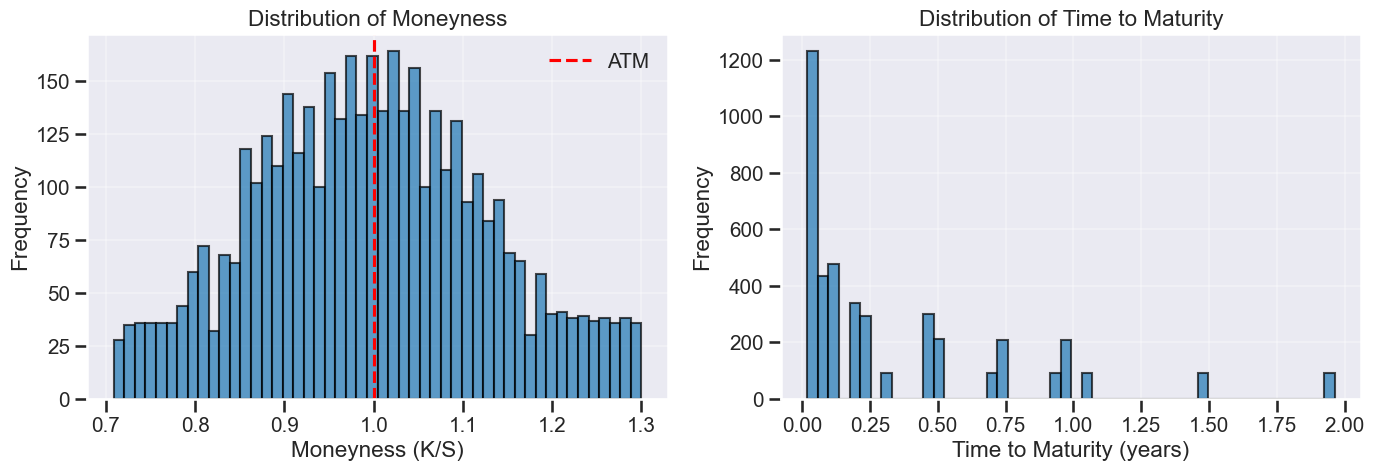

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(iv_df['moneyness'], bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(1.0, color='red', linestyle='--', label='ATM')
axes[0].set_xlabel('Moneyness (K/S)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Moneyness')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(iv_df['T'], bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Time to Maturity (years)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Time to Maturity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Smiles and Surfaces

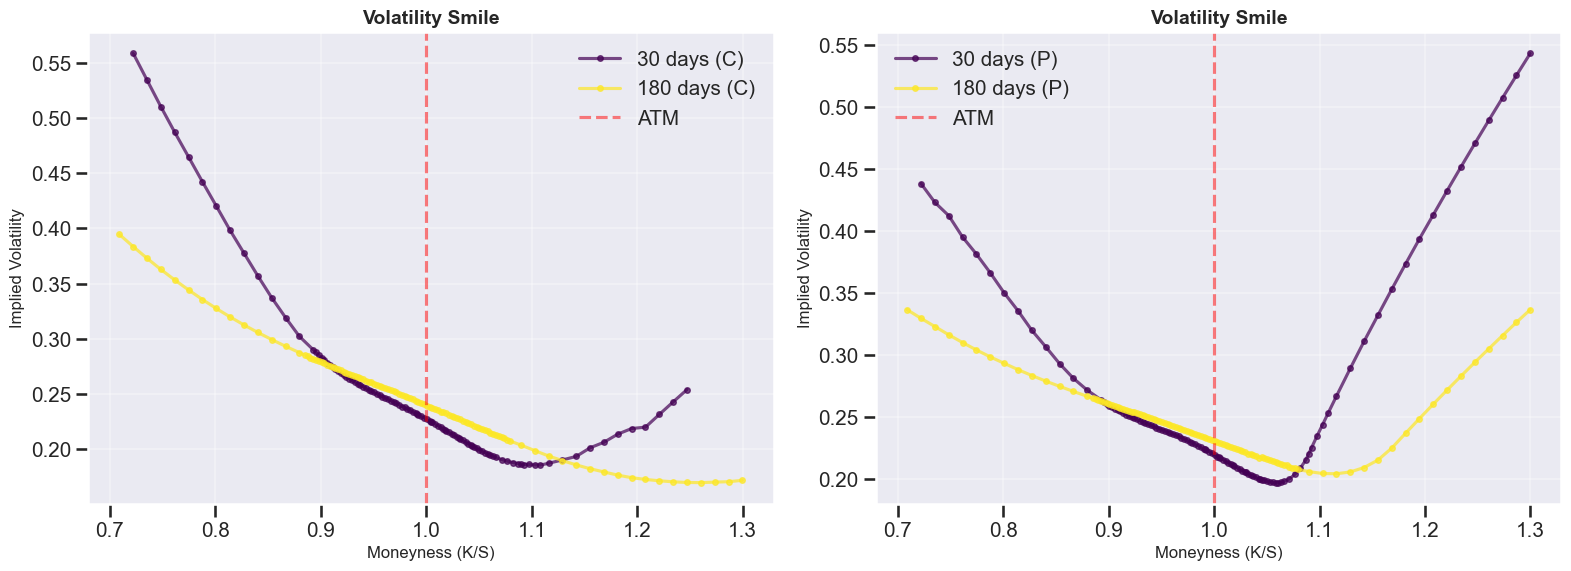

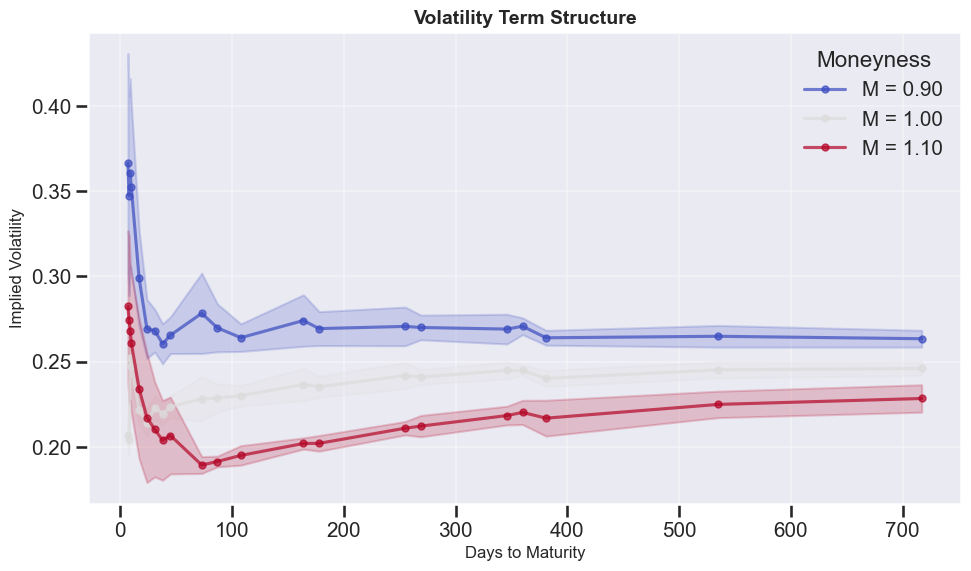

In [31]:
maturity_buckets = [30, 60, 90, 180]
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_volatility_smile(iv_df, maturity_buckets, option_type='C', ax=axes[0])
plot_volatility_smile(iv_df, maturity_buckets, option_type='P', ax=axes[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
plot_term_structure(iv_df, moneyness_levels=[0.9, 1.0, 1.1], ax=ax)
plt.tight_layout()
plt.show()


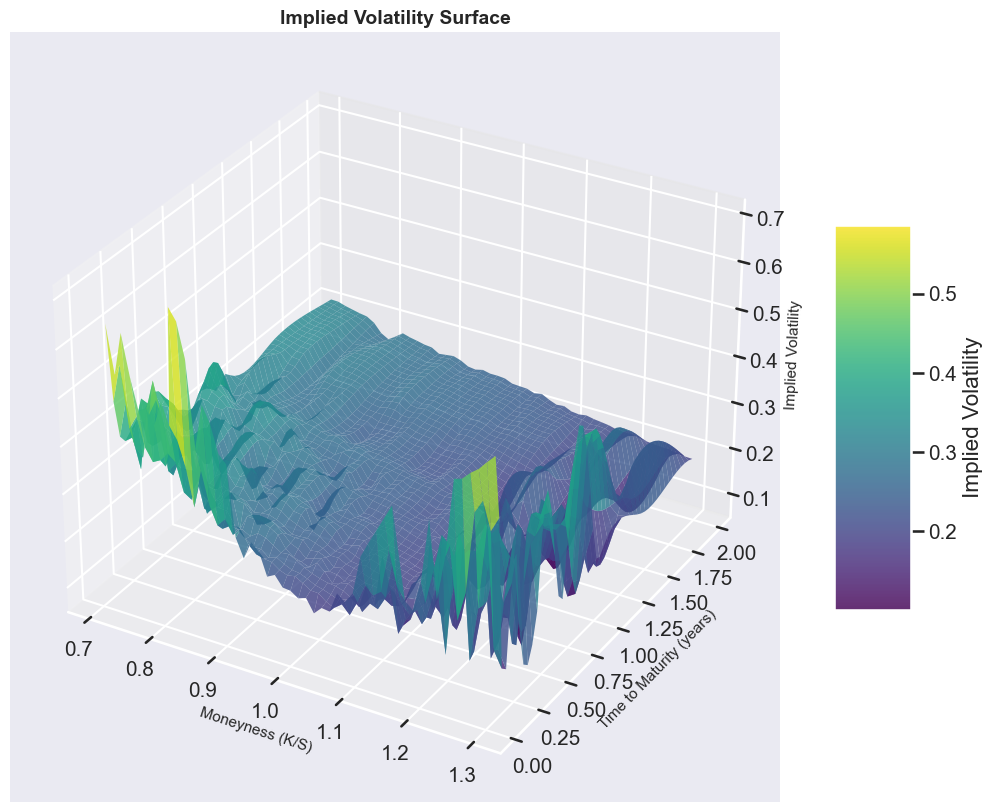

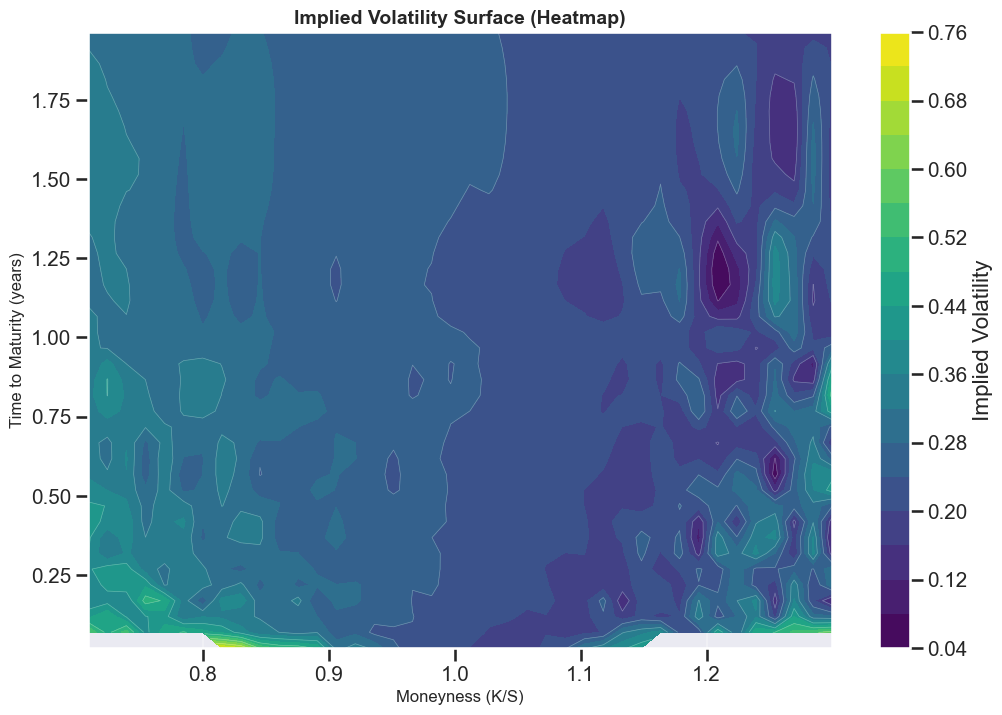

In [32]:
fig = plot_volatility_surface_3d(iv_df, iv_col='computed_iv', interpolate=True, grid_size=50)
plt.show()

fig = plot_volatility_heatmap(iv_df, iv_col='computed_iv', grid_size=(40, 40))
plt.show()


## 9. Arbitrage and Market Quality Checks

Calendar arbitrage violations: 34662
Butterfly arbitrage violations: 265


,moneyness,T1,T2,w1,w2,violation
0,1.076624,0.019178,0.019178,0.000733,0.000722,0.000011
1,1.076624,0.019178,0.019178,0.001039,0.000975,0.000064
2,1.076624,0.019178,0.019178,0.000975,0.000736,0.000239
3,1.076624,0.019178,0.019178,0.001125,0.000681,0.000444
4,1.076624,0.019178,0.019178,0.001616,0.001538,0.000078


,maturity_days,option_type,K1,K2,K3,C1,C2,C3,interpolated,violation
0,24,P,387.0,387.5,388.0,10.755,11.060,11.330,11.042500,0.017500
1,24,P,389.0,390.0,391.0,11.940,12.595,13.185,12.562500,0.032500
2,24,P,392.5,393.0,394.0,14.155,14.515,15.195,14.501667,0.013333
3,8,C,310.0,315.0,320.0,71.315,66.565,61.375,66.345000,0.220000
4,8,C,392.0,392.5,393.0,1.920,1.950,0.645,1.282500,0.667500


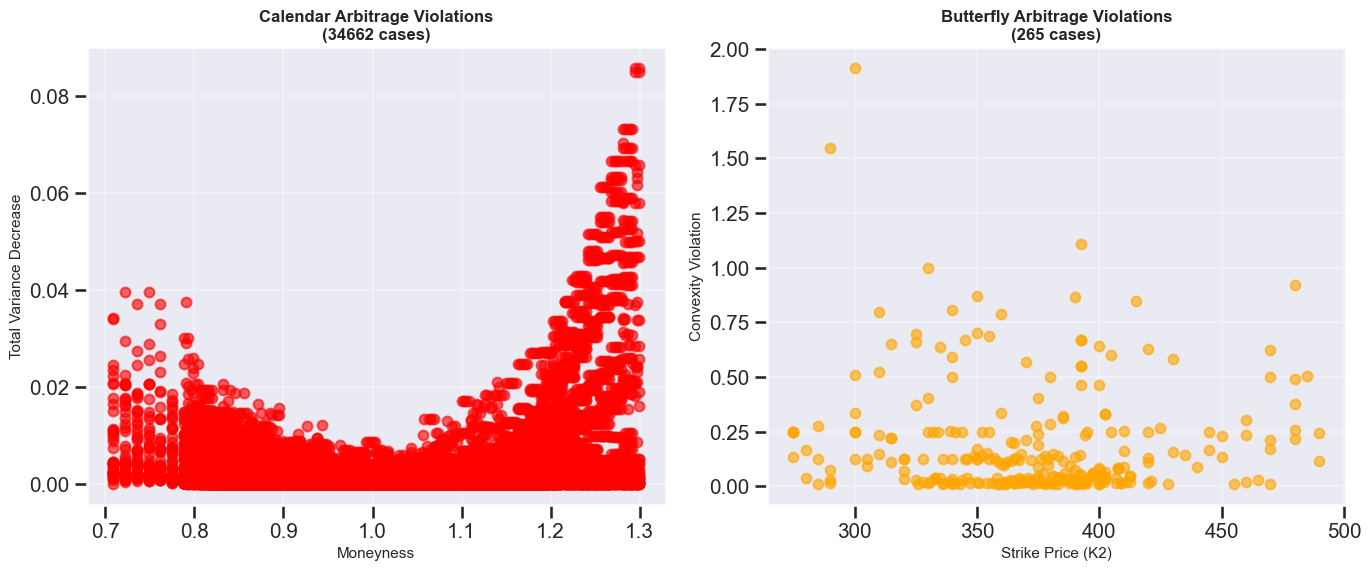

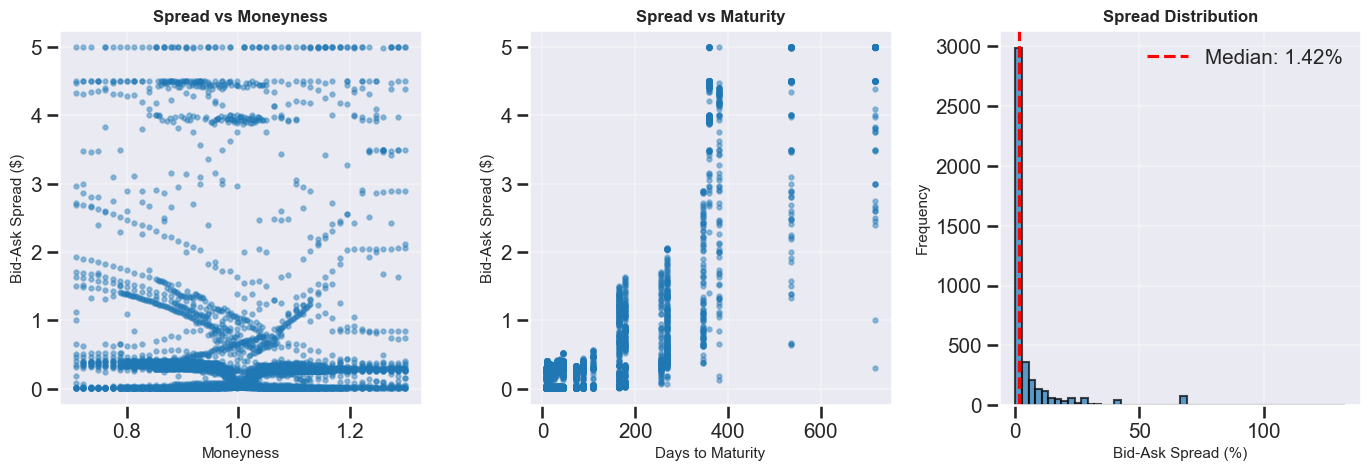

In [33]:
calendar_violations = check_calendar_arbitrage(iv_df, iv_col='computed_iv', moneyness_tolerance=0.02)
butterfly_violations = check_butterfly_arbitrage(iv_df, price_col='mid_price', maturity_tolerance=2)

print(f"Calendar arbitrage violations: {len(calendar_violations)}")
print(f"Butterfly arbitrage violations: {len(butterfly_violations)}")

if len(calendar_violations) > 0:
    display(calendar_violations.head())
if len(butterfly_violations) > 0:
    display(butterfly_violations.head())

fig = plot_arbitrage_analysis(calendar_violations, butterfly_violations)
plt.show()

fig = plot_bid_ask_spread_analysis(iv_df)
plt.show()


## 10. Split and Normalize Data

In [34]:
train_df, test_df = split_data(iv_df, train_ratio=0.8, random_state=42)
print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 3402 samples
Test set: 851 samples


In [35]:
input_features = ['log_moneyness', 'T']
target = 'computed_iv'

X_train, y_train, norm_params = create_model_dataset(
    train_df,
    input_features=input_features,
    target=target,
    normalize=True
)

X_test, y_test, _ = create_model_dataset(
    test_df,
    input_features=input_features,
    target=target,
    normalize=False
)

test_df_normalized = test_df.copy()
for feature in input_features:
    mean = norm_params[feature]['mean']
    std = norm_params[feature]['std'] + 1e-8
    test_df_normalized[feature] = (test_df[feature] - mean) / std
X_test = test_df_normalized[input_features].values

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
print("Normalization parameters:")
norm_params


Training set shape: X=(3402, 2), y=(3402,)
Test set shape: X=(851, 2), y=(851,)
Normalization parameters:


{'log_moneyness': {'mean': -0.010143445142397834,
  'std': 0.13235743632334454,
  'method': 'standard'},
 'T': {'mean': 0.3381532217148656,
  'std': 0.4233318044568121,
  'method': 'standard'}}

## 11. Save Processed Data

In [36]:
processed_path = os.path.join(repo_path, "data", "processed")
os.makedirs(processed_path, exist_ok=True)

train_df.to_parquet(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_train.parquet"))
test_df.to_parquet(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_test.parquet"))

np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_X_train.npy"), X_train)
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_y_train.npy"), y_train)
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_X_test.npy"), X_test)
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_y_test.npy"), y_test)

import json
with open(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_norm_params.json"), 'w') as f:
    json.dump(norm_params, f, indent=4)

print(f"Processed data saved to: {processed_path}")


Processed data saved to: /Users/alex/Desktop/inverse-iv-surface-pinn/data/processed


## Summary

- Loaded WRDS OptionMetrics raw parquet files and extracted spot/zero-curve context
- Cleaned invalid quotes and computed implied vols using Black–Scholes
- Profiled ranges (moneyness, maturities) and visualized smiles, surfaces, and term structures
- Checked calendar/butterfly arbitrage and bid-ask quality for anomalies
- Normalized features, split train/test, and saved processed artifacts for downstream modeling